In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

## 匯入資料

In [2]:
purchase_df = pd.read_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/purchase.csv')
print(purchase_df.shape)
purchase_df.head()

(7792956, 5)


,userid,grass_date,order_count,total_amount,category_encoded
0,295790,2020-05-13,4,4,8
1,428982,2020-05-13,1,2,14
2,151685,2020-05-13,2,2,12
3,323635,2020-05-13,4,11,8
4,118610,2020-05-13,11,11,17


In [3]:
login_df = pd.read_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/login.csv')
print(login_df.shape)
login_df.head()

(50705586, 3)


,userid,date,login_times
0,161097,2020-07-29,2
1,243570,2020-07-29,2
2,355497,2020-07-29,4
3,167925,2020-07-29,1
4,504766,2020-07-29,1


In [4]:
user_df = pd.read_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/user.csv')
print(user_df.shape)
user_df.head()

(502157, 5)


,userid,gender,is_seller,birth_year,enroll_time
0,1,2.0,1,1985.0,2015-05-27
1,2,1.0,1,1980.0,2015-05-27
2,3,2.0,1,2014.0,2015-05-27
3,4,1.0,1,1978.0,2015-05-27
4,5,1.0,1,1978.0,2015-05-27


## 數據清理

In [5]:
# 去除性別為空值的資料
user_df.dropna(subset=["gender"], inplace=True)

# 轉換日期格式
purchase_df["grass_date"] = pd.to_datetime(purchase_df["grass_date"])
print("max grass date:", purchase_df["grass_date"].max())
print("min grass date:", purchase_df["grass_date"].min())
user_df["birth_year"] = pd.to_numeric(user_df["birth_year"], errors="coerce")
print("max birth_year:", user_df["birth_year"].max())
print("min birth_year:", user_df["birth_year"].min())
user_df["enroll_time"] = pd.to_datetime(user_df["enroll_time"])
print("max enroll time:", user_df["enroll_time"].max())
print("min enroll time:", user_df["enroll_time"].min())

# 先把birth_year為空值資料抓出來
no_birth_year_group = user_df[user_df['birth_year'].isnull()]
print(no_birth_year_group.shape)

# 去除出生年份大於註冊年份的資料
birth_year_group = user_df[user_df["birth_year"] <= user_df["enroll_time"].dt.year]
print(birth_year_group.shape)

# 去除出生年份小於1921年的資料，超過100歲的資料應該是錯誤的
birth_year_group = birth_year_group[birth_year_group["birth_year"] >= 2021 - 100]
print(birth_year_group.shape)

max grass date: 2020-07-31 00:00:00
min grass date: 2020-02-01 00:00:00
max birth_year: 2038.0
min birth_year: 1901.0
max enroll time: 2020-02-01 00:00:00
min enroll time: 2015-05-27 00:00:00
(224634, 5)
(275988, 5)
(275634, 5)


### 刪除登入時長超過24小時資料

In [6]:
# 刪除登入時長超過24小時的資料
origin = (login_df.shape[0])
login_df = login_df[(login_df['login_times'] > 0) & (login_df['login_times'] < 24)]
# 共刪除多少筆資料
print("刪除", origin - login_df.shape[0], "筆資料")
print(login_df.shape)


# 計算每個使用者的平均登入時長
average_login_times = login_df.groupby('userid')['login_times'].mean()
average_login_times

刪除 187 筆資料
(50705399, 3)


userid
1         1.388889
2         2.675824
3         4.230769
4         2.393258
5         4.527473
            ...   
521605    1.312500
521606    1.102273
521607    1.233129
521608    1.107843
521609    1.488000
Name: login_times, Length: 502157, dtype: float64

### 合併

In [7]:
# 合併資料
data = pd.concat([birth_year_group, no_birth_year_group], axis=0)
print(data.shape)

# 合併登入時長
data = data.merge(average_login_times, how='inner', left_on='userid', right_on='userid')
# 改欄位名稱
data.rename(columns={'login_times': 'average_login_times'}, inplace=True)
print(data.shape)
data.head()

(500268, 5)
(500268, 6)


,userid,gender,is_seller,birth_year,enroll_time,average_login_times
0,1,2.0,1,1985.0,2015-05-27,1.388889
1,2,1.0,1,1980.0,2015-05-27,2.675824
2,3,2.0,1,2014.0,2015-05-27,4.230769
3,4,1.0,1,1978.0,2015-05-27,2.393258
4,5,1.0,1,1978.0,2015-05-27,4.527473


## 特徵工程

In [8]:
# 計算每個使用者的最近一次消費距離現在的天數
# 首先找出最後一次消費的日期
purchase_df['grass_date'] = pd.to_datetime(purchase_df['grass_date'])
max_purchase_date = purchase_df['grass_date'].max()
print(max_purchase_date)

# 接著計算每個使用者的最近一次消費距離現在的天數
purchase_recency = purchase_df.groupby('userid').agg({'grass_date': lambda x: (max_purchase_date - x.max()).days}).reset_index()
purchase_recency.columns = ['userid', 'purchase_recency']

# 計算每個使用者的消費頻率
purchase_freq = purchase_df.groupby('userid').size().reset_index() # size() is equivalent to count()
purchase_freq.columns = ['userid', 'purchase_freq']
purchase_freq.head()

# 計算每個使用者的總消費金額
total_purchase = purchase_df.groupby('userid').agg({'total_amount': 'sum'}).reset_index()
total_purchase.columns = ['userid', 'total_purchase_amount']
total_purchase.head()

# 合併
data = data.merge(purchase_recency, on='userid', how='inner')
data = data.merge(purchase_freq, on='userid', how='inner')
data = data.merge(total_purchase, on='userid', how='inner')
data.head()

2020-07-31 00:00:00


,userid,gender,is_seller,birth_year,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount
0,1,2.0,1,1985.0,2015-05-27,1.388889,2,10,246
1,2,1.0,1,1980.0,2015-05-27,2.675824,3,18,59
2,3,2.0,1,2014.0,2015-05-27,4.230769,48,7,14
3,4,1.0,1,1978.0,2015-05-27,2.393258,11,35,82
4,5,1.0,1,1978.0,2015-05-27,4.527473,7,65,2734


In [9]:
# 先算年齡，2020-07-31是資料的最後一天
data['age'] = 2020 - data['birth_year']
# 欄位位置調整到birth_year後面
# 得到所有欄位名稱
cols = list(data.columns)

# 移除'age'
cols.remove('age')

# 找到'birth_year'的index
birth_year_index = cols.index('birth_year')

# 插入'age'到birth_year的後面
cols.insert(birth_year_index + 1, 'age')

# 重新排列欄位
data = data[cols]

data['age'].describe()

count    275634.000000
mean         31.696982
std           9.979175
min           0.000000
25%          24.000000
50%          30.000000
75%          38.000000
max          99.000000
Name: age, dtype: float64

In [10]:
data.head()

,userid,gender,is_seller,birth_year,age,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount
0,1,2.0,1,1985.0,35.0,2015-05-27,1.388889,2,10,246
1,2,1.0,1,1980.0,40.0,2015-05-27,2.675824,3,18,59
2,3,2.0,1,2014.0,6.0,2015-05-27,4.230769,48,7,14
3,4,1.0,1,1978.0,42.0,2015-05-27,2.393258,11,35,82
4,5,1.0,1,1978.0,42.0,2015-05-27,4.527473,7,65,2734


In [11]:
data.to_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/data.csv', index=False) 

## 建立RFM模型  
* RFM模型是一種用於客戶分群的方法，透過客戶的最近一次消費時間、消費頻率和消費金額進行分群。
    * Recency: 最近一次消費時間
    * Frequency: 消費頻率
    * Monetary: 消費金額

### 五等分法

In [12]:
# 匯入資料
data = pd.read_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/data.csv')

In [13]:
# 將消費距離現在的天數、消費頻率、總消費金額分別分成五個等級

data['R_score'] = pd.qcut(data['purchase_recency'], 5, labels=range(5, 0, -1))
data['F_score'] = pd.qcut(data['purchase_freq'], 5, labels=range(1, 6))
data['M_score'] = pd.qcut(data['total_purchase_amount'], 5, labels=range(1, 6))
data.head()


,userid,gender,is_seller,birth_year,age,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount,R_score,F_score,M_score
0,1,2.0,1,1985.0,35.0,2015-05-27,1.388889,2,10,246,5,3,5
1,2,1.0,1,1980.0,40.0,2015-05-27,2.675824,3,18,59,5,4,4
2,3,2.0,1,2014.0,6.0,2015-05-27,4.230769,48,7,14,1,2,2
3,4,1.0,1,1978.0,42.0,2015-05-27,2.393258,11,35,82,3,5,4
4,5,1.0,1,1978.0,42.0,2015-05-27,4.527473,7,65,2734,4,5,5


In [14]:
# 找出三種重要客戶
data['RFM_score'] = data['R_score'].astype(str) + data['F_score'].astype(str) + data['M_score'].astype(str)

# 重要價值戶: R=4,5, F=4,5, M=4,5
valuable_customers = data[(data['R_score'].isin([4, 5])) & 
                          (data['F_score'].isin([4, 5])) & 
                          (data['M_score'].isin([4, 5]))] 

# 重要保留戶 R=1,2, F=4,5, M=4,5
retained_customers = data[(data['R_score'].isin([1, 2])) & 
                          (data['F_score'].isin([4, 5])) & 
                          (data['M_score'].isin([4, 5]))]

# 重要發展戶 R=4,5, F=1,2, M=4,5
developing_customers = data[(data['R_score'].isin([4, 5])) & 
                            (data['F_score'].isin([1, 2])) & 
                            (data['M_score'].isin([4, 5]))]

# 觀察三種重要客戶的數量
print("valuable_customers:", valuable_customers.shape[0])
print("retained_customers:", retained_customers.shape[0])
print("developing_customers:", developing_customers.shape[0], "\n")

# 用性別和是否為賣家來看這三種重要客戶的比例
valuable_customers_ratio = valuable_customers.groupby(['gender', 'is_seller']).agg({'is_seller': ['count', lambda x: x.count() / len(valuable_customers) * 100]}).rename(columns={'count': 'Count', '<lambda_0>': 'Ratio'}).reset_index()
retained_customers_ratio = retained_customers.groupby(['gender', 'is_seller']).agg({'is_seller': ['count', lambda x: x.count() / len(retained_customers) * 100]}).rename(columns={'count': 'Count', '<lambda_0>': 'Ratio'}).reset_index()
developing_customers_ratio = developing_customers.groupby(['gender', 'is_seller']).agg({'is_seller': ['count', lambda x: x.count() / len(developing_customers) * 100]}).rename(columns={'count': 'Count', '<lambda_0>': 'Ratio'}).reset_index()

print("Valuable Customers Gender and Seller Ratio:")
print(valuable_customers_ratio.to_string(index=False))
print("\nRetained Customers Gender and Seller Ratio:")
print(retained_customers_ratio.to_string(index=False))
print("\nDeveloping Customers Gender and Seller Ratio:")
print(developing_customers_ratio.to_string(index=False))

valuable_customers: 96539
retained_customers: 24810
developing_customers: 4535 

Valuable Customers Gender and Seller Ratio:
gender is_seller                
                 Count     Ratio
   1.0         0 16042 16.617118
   1.0         1 10984 11.377785
   2.0         0 32902 34.081563
   2.0         1 36611 37.923533

Retained Customers Gender and Seller Ratio:
gender is_seller                
                 Count     Ratio
   1.0         0  4456 17.960500
   1.0         1  2538 10.229746
   2.0         0  9209 37.118098
   2.0         1  8607 34.691657

Developing Customers Gender and Seller Ratio:
gender is_seller                
                 Count     Ratio
   1.0         0  1114 24.564498
   1.0         1   500 11.025358
   2.0         0  1911 42.138920
   2.0         1  1010 22.271224


In [15]:
# 觀察三種重要客戶的平均消費距離現在的天數
print(f"Valuable Customers Average Purchase Recency: {valuable_customers['purchase_recency'].mean():.2f} days")
print(f"Retained Customers Average Purchase Recency: {retained_customers['purchase_recency'].mean():.2f} days")
print(f"Developing Customers Average Purchase Recency: {developing_customers['purchase_recency'].mean():.2f} days", end="\n\n")

# 觀察三種重要客戶的平均消費頻率
print(f"Valuable Customers Average Purchase Frequency: {valuable_customers['purchase_freq'].mean():.2f}")
print(f"Retained Customers Average Purchase Frequency: {retained_customers['purchase_freq'].mean():.2f}")
print(f"Developing Customers Average Purchase Frequency: {developing_customers['purchase_freq'].mean():.2f}", end="\n\n")

# 觀察三種重要客戶的平均總消費金額
print(f"Valuable Customers Average Total Purchase Amount: {valuable_customers['total_purchase_amount'].mean():.2f}")
print(f"Retained Customers Average Total Purchase Amount: {retained_customers['total_purchase_amount'].mean():.2f}")
print(f"Developing Customers Average Total Purchase Amount: {developing_customers['total_purchase_amount'].mean():.2f}", end="\n\n")

Valuable Customers Average Purchase Recency: 3.05 days
Retained Customers Average Purchase Recency: 27.73 days
Developing Customers Average Purchase Recency: 3.54 days

Valuable Customers Average Purchase Frequency: 32.42
Retained Customers Average Purchase Frequency: 25.09
Developing Customers Average Purchase Frequency: 6.99

Valuable Customers Average Total Purchase Amount: 708.14
Retained Customers Average Total Purchase Amount: 402.25
Developing Customers Average Total Purchase Amount: 377.22



In [16]:
# 分成有出生年份和沒有出生年份的兩群，觀察三種重要客戶的比例
valuable_customers_birth_year_ratio = valuable_customers.groupby(valuable_customers['birth_year'].isnull()).size().rename({True: '無', False: '有'}).apply(lambda x: x / len(valuable_customers) * 100)
retained_customers_birth_year_ratio = retained_customers.groupby(retained_customers['birth_year'].isnull()).size().rename({True: '無', False: '有'}).apply(lambda x: x / len(retained_customers) * 100)
developing_customers_birth_year_ratio = developing_customers.groupby(developing_customers['birth_year'].isnull()).size().rename({True: '無', False: '有'}).apply(lambda x: x / len(developing_customers) * 100)

print(f"Valuable Customers Birth Year Ratio:\n{valuable_customers_birth_year_ratio}\n")
print(f"Retained Customers Birth Year Ratio:\n{retained_customers_birth_year_ratio}\n")
print(f"Developing Customers Birth Year Ratio:\n{developing_customers_birth_year_ratio}\n")

Valuable Customers Birth Year Ratio:
birth_year
有    60.465719
無    39.534281
dtype: float64

Retained Customers Birth Year Ratio:
birth_year
有    60.245869
無    39.754131
dtype: float64

Developing Customers Birth Year Ratio:
birth_year
有    52.370452
無    47.629548
dtype: float64



In [17]:
# 看這三種重要客戶占總使用者的比例
total_users = data.shape[0]
valuable_customers_ratio = valuable_customers.shape[0] / total_users * 100
retained_customers_ratio = retained_customers.shape[0] / total_users * 100
developing_customers_ratio = developing_customers.shape[0] / total_users * 100

print(f"Valuable Customers Ratio: {valuable_customers_ratio:.2f}%")
print(f"Retained Customers Ratio: {retained_customers_ratio:.2f}%")
print(f"Developing Customers Ratio: {developing_customers_ratio:.2f}%")

Valuable Customers Ratio: 19.30%
Retained Customers Ratio: 4.96%
Developing Customers Ratio: 0.91%


In [18]:
# 將三種重要客戶的資料新增欄位至data
data['quintile_label'] = 0
data.loc[data['userid'].isin(valuable_customers['userid']), 'quintile_label'] = 1
data.loc[data['userid'].isin(retained_customers['userid']), 'quintile_label'] = 1
data.loc[data['userid'].isin(developing_customers['userid']), 'quintile_label'] = 1

data.head()

,userid,gender,is_seller,birth_year,age,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount,R_score,F_score,M_score,RFM_score,quintile_label
0,1,2.0,1,1985.0,35.0,2015-05-27,1.388889,2,10,246,5,3,5,535,0
1,2,1.0,1,1980.0,40.0,2015-05-27,2.675824,3,18,59,5,4,4,544,1
2,3,2.0,1,2014.0,6.0,2015-05-27,4.230769,48,7,14,1,2,2,122,0
3,4,1.0,1,1978.0,42.0,2015-05-27,2.393258,11,35,82,3,5,4,354,0
4,5,1.0,1,1978.0,42.0,2015-05-27,4.527473,7,65,2734,4,5,5,455,1


### 自訂權重法
| |   權重   |
|:-:|:---------:|
|R|  20      |
|F|  30      |
|M|  50      |

In [19]:
# # 匯入資料
# data = pd.read_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/data.csv')

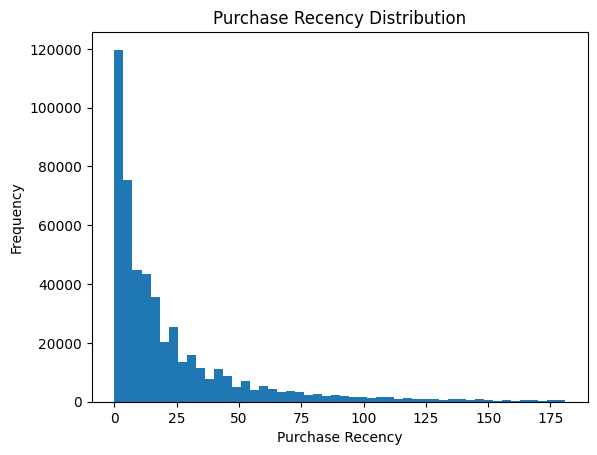

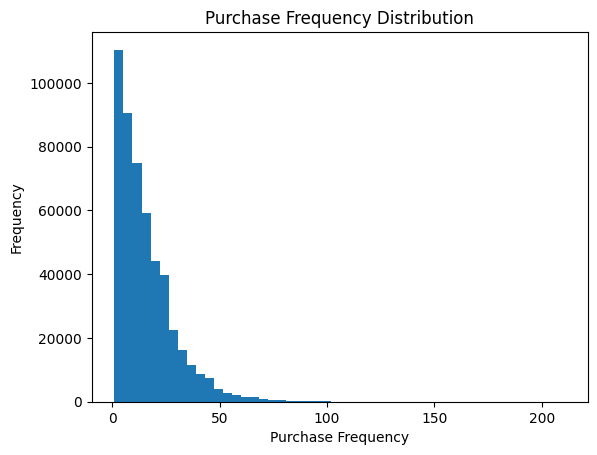

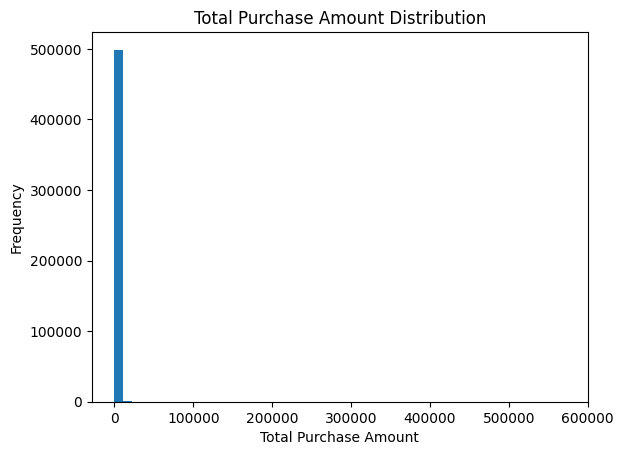

In [20]:
# 看消費距離現在的天數的分布
plt.hist(data['purchase_recency'], bins=50)
plt.xlabel('Purchase Recency')
plt.ylabel('Frequency')
plt.title('Purchase Recency Distribution')
plt.show()

# 看消費頻率的分布
plt.hist(data['purchase_freq'], bins=50)
plt.xlabel('Purchase Frequency')
plt.ylabel('Frequency')
plt.title('Purchase Frequency Distribution')
plt.show()

# 看總消費金額的分布
plt.hist(data['total_purchase_amount'], bins=50)
plt.xlabel('Total Purchase Amount')
plt.ylabel('Frequency')
plt.title('Total Purchase Amount Distribution')
plt.show()

In [21]:
print(data['purchase_recency'].describe(), end='\n\n')
print(data['purchase_freq'].describe(), end='\n\n')
print(data['total_purchase_amount'].describe())

count    500268.000000
mean         22.343266
std          29.587422
min           0.000000
25%           4.000000
50%          11.000000
75%          28.000000
max         181.000000
Name: purchase_recency, dtype: float64

count    500268.000000
mean         15.511894
std          13.154228
min           1.000000
25%           6.000000
50%          12.000000
75%          21.000000
max         211.000000
Name: purchase_freq, dtype: float64

count    500268.000000
mean        224.327586
std        2958.337220
min           1.000000
25%          15.000000
50%          39.000000
75%          91.000000
max      571849.000000
Name: total_purchase_amount, dtype: float64


In [22]:
# 將消費距離現在的天數、消費頻率、總消費金額分別分成四個區間
quantiles = data[['purchase_recency','purchase_freq', 'total_purchase_amount']].quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict() # convert to dictionary
print(quantiles)

# 創建函數，將數值轉換成分數
def RScore(vaule, col, quantiles):
    if vaule <= quantiles[col][0.25]:
        return 20
    elif vaule <= quantiles[col][0.50]:
        return 15
    elif vaule <= quantiles[col][0.75]:
        return 10
    else:
        return 5

def FScore(vaule, col, quantiles):
    if vaule <= quantiles[col][0.25]:
        return 7
    elif vaule <= quantiles[col][0.50]:
        return 15
    elif vaule <= quantiles[col][0.75]:
        return 22
    else:
        return 30

def MScore(vaule, col, quantiles):
    if vaule <= quantiles[col][0.25]:
        return 10
    elif vaule <= quantiles[col][0.50]:
        return 20
    elif vaule <= quantiles[col][0.75]:
        return 35
    else:
        return 50


# 計算每個使用者的R、F、M分數
data['r_quartile'] = data['purchase_recency'].apply(RScore, args=('purchase_recency',quantiles))
data['f_quartile'] = data['purchase_freq'].apply(FScore, args=('purchase_freq',quantiles))
data['m_quartile'] = data['total_purchase_amount'].apply(MScore, args=('total_purchase_amount',quantiles))
data.head()

# 計算每個使用者的RFM分數
data['RFM_Score'] = data['r_quartile'].map(int) + data['f_quartile'].map(int) + data['m_quartile'].map(int)
data.head()

{'purchase_recency': {0.25: 4.0, 0.5: 11.0, 0.75: 28.0}, 'purchase_freq': {0.25: 6.0, 0.5: 12.0, 0.75: 21.0}, 'total_purchase_amount': {0.25: 15.0, 0.5: 39.0, 0.75: 91.0}}


,userid,gender,is_seller,birth_year,age,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount,R_score,F_score,M_score,RFM_score,quintile_label,r_quartile,f_quartile,m_quartile,RFM_Score
0,1,2.0,1,1985.0,35.0,2015-05-27,1.388889,2,10,246,5,3,5,535,0,20,15,50,85
1,2,1.0,1,1980.0,40.0,2015-05-27,2.675824,3,18,59,5,4,4,544,1,20,22,35,77
2,3,2.0,1,2014.0,6.0,2015-05-27,4.230769,48,7,14,1,2,2,122,0,5,15,10,30
3,4,1.0,1,1978.0,42.0,2015-05-27,2.393258,11,35,82,3,5,4,354,0,15,30,35,80
4,5,1.0,1,1978.0,42.0,2015-05-27,4.527473,7,65,2734,4,5,5,455,1,15,30,50,95


In [23]:
# 先計算RFM分數的四分位數
rfm_score_quantiles = {
    '0.50': data['RFM_Score'].quantile(0.50),
    '0.80': data['RFM_Score'].quantile(0.80),
    '0.25': data['RFM_Score'].quantile(0.25)
}

# 創建函數，用RFM分數將客戶分群，High Value、Mid Value、Low Value
def RFMSegment(value):
    if value >= rfm_score_quantiles['0.80']:
        return 'High Value'
    elif value >= rfm_score_quantiles['0.50']:
        return 'High-Mid Value'
    elif value >= rfm_score_quantiles['0.25']:
        return 'Low-Mid Value'
    else:
        return 'Low Value'

data['RFM_Segment'] = data['RFM_Score'].apply(RFMSegment)
data.head()

# 計算每個群的人數並用群名排序，High Value > Mid Value > Low Value
sort_order = ['High Value', 'High-Mid Value', 'Low-Mid Value', 'Low Value']

# 計算每個群的人數和比例
rfm_segments = data['RFM_Segment'].value_counts().reindex(sort_order)
rfm_segments = pd.DataFrame(rfm_segments)
rfm_segments.columns = ['Count']
rfm_segments['Ratio'] = rfm_segments['Count'] / rfm_segments['Count'].sum() * 100
rfm_segments

,Count,Ratio
RFM_Segment,,
High Value,118590,23.705294
High-Mid Value,131622,26.310298
Low-Mid Value,134620,26.909576
Low Value,115436,23.074832


In [24]:
# 觀察每個群的平均消費距離現在的天數
print(data.groupby('RFM_Segment')['purchase_recency'].mean().loc[sort_order], end='\n\n')

# 觀察每個群的平均消費頻率
print(data.groupby('RFM_Segment')['purchase_freq'].mean().loc[sort_order], end='\n\n')

# 觀察每個群的平均總消費金額
print(data.groupby('RFM_Segment')['total_purchase_amount'].mean().loc[sort_order], end='\n\n')

RFM_Segment
High Value         6.029050
High-Mid Value    14.133177
Low-Mid Value     18.935894
Low Value         52.438139
Name: purchase_recency, dtype: float64

RFM_Segment
High Value        32.434573
High-Mid Value    16.582198
Low-Mid Value      9.444562
Low Value          3.982111
Name: purchase_freq, dtype: float64

RFM_Segment
High Value        764.361160
High-Mid Value    129.808125
Low-Mid Value      25.918393
Low Value           8.693856
Name: total_purchase_amount, dtype: float64



In [25]:
# 分將四種客戶分成有出生年份和沒有出生年份的兩群，觀察每個群的人數和比例
data['has_birth_year'] = data['birth_year'].notnull()
data['has_birth_year'] = data['has_birth_year'].map({True: '有', False: '無'})

# 觀察每個群的人數和比例
group_counts = data.groupby(['RFM_Segment', 'has_birth_year']).size().unstack().loc[sort_order]
group_counts['有比例'] = group_counts['有'] / group_counts.sum(axis=1)
group_counts['無比例'] = group_counts['無'] / group_counts.sum(axis=1)
(group_counts)


has_birth_year,有,無,有比例,無比例
RFM_Segment,,,,
High Value,71969,46621,0.606872,0.393126
High-Mid Value,75273,56349,0.571888,0.428110
Low-Mid Value,72424,62196,0.537988,0.462010
Low Value,55968,59468,0.484840,0.515158


In [26]:
# 每種客戶類型中性別、是否為賣家比例
group_counts = data.groupby(['RFM_Segment', 'gender', 'is_seller']).size().unstack()
group_counts['賣家比例'] = group_counts[1] / group_counts.sum(axis=1)
group_counts['非賣家比例'] = group_counts[0] / group_counts.sum(axis=1)
group_counts.rename(columns={0: '非賣家', 1: '賣家'}, inplace=True)
(group_counts)

is_seller                非賣家     賣家      賣家比例     非賣家比例
RFM_Segment    gender                                  
High Value     1.0     19601  13598  0.409591  0.590402
               2.0     40448  44943  0.526320  0.473677
High-Mid Value 1.0     28765  14610  0.336830  0.663165
               2.0     49773  38474  0.435981  0.564016
Low Value      1.0     44144  11488  0.206500  0.793497
               2.0     43227  16577  0.277189  0.722808
Low-Mid Value  1.0     39644  14750  0.271170  0.728827
               2.0     51715  28511  0.355384  0.644614

## 將自訂權重法與 user_train 比較

In [27]:
user_train_df = pd.read_csv('/Users/joelin/Downloads/台灣大學_商業智慧與數據分析企業實作_安永_備選題目/user_train.csv')
print(user_train_df.shape)
user_train_df.head()

(426832, 2)


,userid,label
0,243381,0
1,150139,1
2,305902,1
3,159981,0
4,490632,0


In [28]:
# 觀察訓練資料中的高價值客戶數量分佈
user_train_df['label'].value_counts()
# 看高價值客戶的比例
user_train_df['label'].value_counts(normalize=True) # normalize=True to get the proportion

label
0    0.658207
1    0.341793
Name: proportion, dtype: float64

In [29]:
# 將RFM_Segment轉換成標籤，High Value=1, High-Mid Value=1, Low-Mid Value=0, Low Value=0
data['RFM_self_defined_label'] = data['RFM_Segment'].map({'High Value': 1, 'High-Mid Value': 0, 'Low-Mid Value': 0, 'Low Value': 0})

# 將 'userid' 列的數據類型轉換為 int64
data['userid'] = data['userid'].astype('int64')
user_train_df['userid'] = user_train_df['userid'].astype('int64')

# 將data裡面的RFM_Segment和user_train_df做比較計算準確度
data = data.merge(user_train_df, on='userid', how='inner')

# 現在你可以進行合併操作
data.head()

# 計算準確度
accuracy = (data['RFM_self_defined_label'] == data['label']).mean()
accuracy


0.6749313886190945

In [30]:
# 分類報告
from sklearn.metrics import classification_report
print(classification_report(data['label'], data['RFM_self_defined_label']))

# 混淆矩陣
from sklearn.metrics import confusion_matrix
confusion_matrix(data['label'], data['RFM_self_defined_label'])

              precision    recall  f1-score   support

           0       0.72      0.83      0.77    279946
           1       0.53      0.37      0.44    145275

    accuracy                           0.67    425221
   macro avg       0.63      0.60      0.60    425221
weighted avg       0.66      0.67      0.66    425221



array([[233108,  46838],
       [ 91388,  53887]])

In [31]:
data.head()

,userid,gender,is_seller,birth_year,age,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount,...,RFM_score,quintile_label,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Segment,has_birth_year,RFM_self_defined_label,label
0,1,2.0,1,1985.0,35.0,2015-05-27,1.388889,2,10,246,...,535,0,20,15,50,85,High Value,有,1,0
1,2,1.0,1,1980.0,40.0,2015-05-27,2.675824,3,18,59,...,544,1,20,22,35,77,High-Mid Value,有,0,0
2,3,2.0,1,2014.0,6.0,2015-05-27,4.230769,48,7,14,...,122,0,5,15,10,30,Low Value,有,0,0
3,4,1.0,1,1978.0,42.0,2015-05-27,2.393258,11,35,82,...,354,0,15,30,35,80,High-Mid Value,有,0,0
4,5,1.0,1,1978.0,42.0,2015-05-27,4.527473,7,65,2734,...,455,1,15,30,50,95,High Value,有,1,1


In [32]:
# 將年齡分成四個區間
data['age_segment'] = pd.cut(data['age'], bins=[0, 25, 35, 45, 100], labels=['0-25', '25-35', '35-45', '45-100'])
data['age_segment'].value_counts()

data.head()

,userid,gender,is_seller,birth_year,age,enroll_time,average_login_times,purchase_recency,purchase_freq,total_purchase_amount,...,quintile_label,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Segment,has_birth_year,RFM_self_defined_label,label,age_segment
0,1,2.0,1,1985.0,35.0,2015-05-27,1.388889,2,10,246,...,0,20,15,50,85,High Value,有,1,0,25-35
1,2,1.0,1,1980.0,40.0,2015-05-27,2.675824,3,18,59,...,1,20,22,35,77,High-Mid Value,有,0,0,35-45
2,3,2.0,1,2014.0,6.0,2015-05-27,4.230769,48,7,14,...,0,5,15,10,30,Low Value,有,0,0,0-25
3,4,1.0,1,1978.0,42.0,2015-05-27,2.393258,11,35,82,...,0,15,30,35,80,High-Mid Value,有,0,0,35-45
4,5,1.0,1,1978.0,42.0,2015-05-27,4.527473,7,65,2734,...,1,15,30,50,95,High Value,有,1,1,35-45


   gender age_segment  proportion
0     1.0        0-25    4.038851
1     1.0       25-35    9.575512
2     1.0       35-45    9.931977
3     1.0      45-100    4.539211
4     2.0        0-25   18.258225
5     2.0       25-35   27.563935
6     2.0       35-45   20.145202
7     2.0      45-100    5.940545


/var/folders/2n/rlvj6ngx3yvf9k0w2jw4wyt80000gn/T/ipykernel_59920/373294119.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data_high_value.groupby(['gender', 'age_segment']).size()
/var/folders/2n/rlvj6ngx3yvf9k0w2jw4wyt80000gn/T/ipykernel_59920/373294119.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_segment', y='proportion', hue='gender', data=proportions, ci=None, palette=palette)
/Users/joelin/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals =

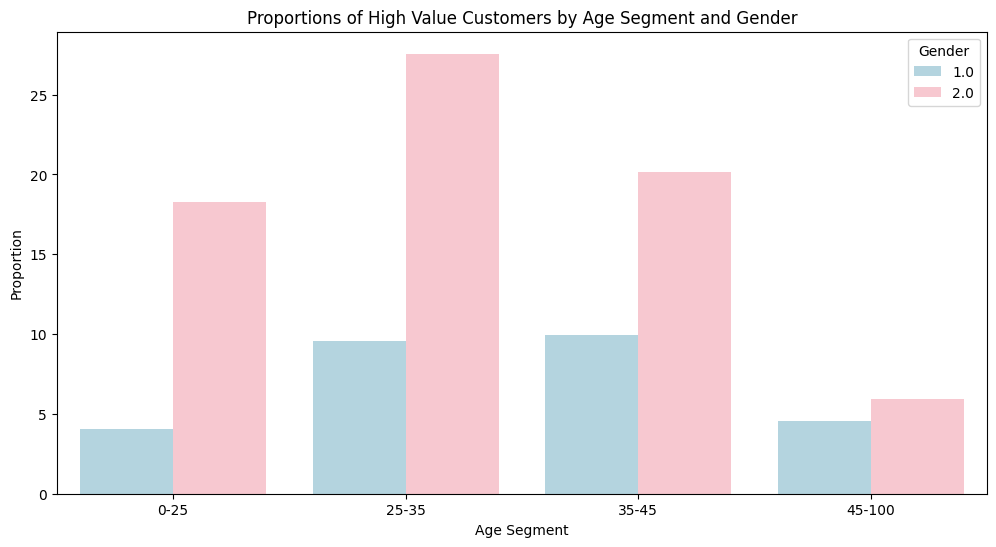

In [33]:
# 區分高價值客戶和非高價值客戶
data_high_value = data[data['RFM_Segment'] == 'High Value']
data_low_value = data[data['RFM_Segment'] != 'High Value']

# 计算每个组的大小
counts = data_high_value.groupby(['gender', 'age_segment']).size()

# 计算比例
proportions = counts / data_high_value['age'].notnull().sum()

# 将结果转换为 DataFrame
proportions = proportions.reset_index(name='proportion')

# 計算總比例
proportions['proportion'] = proportions['proportion'] * 100

print(proportions)

# 画图
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个新的figure
plt.figure(figsize=(12, 6))

# 定义颜色
palette = {1: 'lightblue', 2: 'pink'}    

# 绘制比例
sns.barplot(x='age_segment', y='proportion', hue='gender', data=proportions, ci=None, palette=palette)
plt.title('Proportions of High Value Customers by Age Segment and Gender')
plt.xlabel('Age Segment')
plt.ylabel('Proportion')
plt.legend(title='Gender')
plt.show()

In [34]:
# 我想要看看高價值客戶中有年齡資料的比例
print(data_high_value['age'].notnull().sum() / data_high_value.shape[0])
print(data_low_value['age'].notnull().sum() / data_low_value.shape[0])


0.6071581037478282
0.5330420097628322


In [35]:
# 觀察兩類客戶的年齡分佈
print(data_high_value['age'].describe())
print(data_low_value['age'].describe())

count    61156.000000
mean        33.487704
std          9.449576
min          0.000000
25%         26.000000
50%         33.000000
75%         40.000000
max         98.000000
Name: age, dtype: float64
count    172970.000000
mean         31.090738
std          10.080385
min           0.000000
25%          23.000000
50%          30.000000
75%          38.000000
max          99.000000
Name: age, dtype: float64


In [36]:
# 將高價值客戶區分為重要價值戶、重要保留戶、重要發展戶
total_users = data_high_value.shape[0]

# 重要價值戶: R高、F高、M高
valuable_customers = data_high_value[((data_high_value['r_quartile'] == 20) |
                                        (data_high_value['r_quartile'] == 15)) & 
                                        ((data_high_value['f_quartile'] == 22) | 
                                        (data_high_value['f_quartile'] == 30)) & 
                                        ((data_high_value['m_quartile'] == 35) | 
                                        (data_high_value['m_quartile'] == 50))]

# 重要保留戶: R低、F高、M高
retained_customers = data_high_value[((data_high_value['r_quartile'] == 10) | 
                                      (data_high_value['r_quartile'] == 5)) & 
                                      ((data_high_value['f_quartile'] == 22) | 
                                      (data_high_value['f_quartile'] == 30)) & 
                                      ((data_high_value['m_quartile'] == 35) | 
                                      (data_high_value['m_quartile'] == 50))]

# 重要發展戶: R高、F低、M高
developing_customers = data_high_value[((data_high_value['r_quartile'] == 20) | 
                                        (data_high_value['r_quartile'] == 15)) & 
                                        ((data_high_value['f_quartile'] == 7) | 
                                        (data_high_value['f_quartile'] == 15)) & 
                                        ((data_high_value['m_quartile'] == 35) | 
                                        (data_high_value['m_quartile'] == 50))]

# 觀察三種重要客戶的比例
proportion1 = valuable_customers.shape[0] / total_users * 100
proportion2 = retained_customers.shape[0] / total_users * 100
proportion3 = developing_customers.shape[0] / total_users * 100

print(f"Valuable Customers Ratio: {proportion1:.2f}%")
print(f"Retained Customers Ratio: {proportion2:.2f}%")
print(f"Developing Customers Ratio: {proportion3:.2f}%")



Valuable Customers Ratio: 83.29%
Retained Customers Ratio: 14.42%
Developing Customers Ratio: 2.29%


In [37]:
# 從 'data' 中找到 'RFM_Segment' 為 'High Value' 的使用者
high_value_users = data[data['RFM_Segment'] == 'High Value']

# 從 'purchase_df' 中找到這些使用者的購買資訊
high_value_purchases = purchase_df[purchase_df['userid'].isin(high_value_users['userid'])]

# 顯示這些購買資訊
high_value_purchases.head()

# 計算每個產品的銷售額
product_sales = high_value_purchases.groupby('category_encoded').agg({'total_amount': 'sum'}).reset_index()
product_sales.columns = ['product_id', 'total_sales']
product_sales = product_sales.sort_values('total_sales', ascending=False)
product_sales.head()


,product_id,total_sales
22,23,11650232
20,21,10083351
9,10,9963888
1,2,9340565
7,8,8009965


In [38]:
data_high_value.dtypes

userid                       int64
gender                     float64
is_seller                    int64
birth_year                 float64
age                        float64
enroll_time                 object
average_login_times        float64
purchase_recency             int64
purchase_freq                int64
total_purchase_amount        int64
R_score                   category
F_score                   category
M_score                   category
RFM_score                   object
quintile_label               int64
r_quartile                   int64
f_quartile                   int64
m_quartile                   int64
RFM_Score                    int64
RFM_Segment                 object
has_birth_year              object
RFM_self_defined_label       int64
label                        int64
age_segment               category
dtype: object

In [39]:
# 觀察高價值客戶與非高價值客戶的平均登入時長
print(data_high_value['average_login_times'].mean())
print(data_low_value['average_login_times'].mean())


1.592240865070579
1.3338118301640183


In [40]:
# 觀察高價值客戶與非高價值客戶的賣家比例
print(data_high_value['is_seller'].value_counts(normalize=True))
print(data_low_value['is_seller'].value_counts(normalize=True))

is_seller
0    0.505882
1    0.494118
Name: proportion, dtype: float64
is_seller
0    0.674409
1    0.325591
Name: proportion, dtype: float64


In [41]:
# 觀察高價值客戶與非高價值客戶的性別比例
print(data_high_value['gender'].value_counts(normalize=True))
print(data_low_value['gender'].value_counts(normalize=True))

gender
2.0    0.720109
1.0    0.279891
Name: proportion, dtype: float64
gender
2.0    0.598057
1.0    0.401943
Name: proportion, dtype: float64


In [42]:
# 觀察高價值客戶與非高價值客戶的平均消費距離現在的天數
print('high_value_users:', data_high_value['purchase_recency'].mean())
print('low_value_users:', data_low_value['purchase_recency'].mean())

# 觀察高價值客戶與非高價值客戶的平均消費頻率
print(data_high_value['purchase_freq'].mean())
print(data_low_value['purchase_freq'].mean())

# 觀察高價值客戶與非高價值客戶的平均總消費金額
print(data_high_value['total_purchase_amount'].mean())
print(data_low_value['total_purchase_amount'].mean())

high_value_users: 6.034619012161826
low_value_users: 27.409829396972537
32.450265574584265
10.250536216162912
763.610285430628
56.92129024702924
